# Summarize recorded interactions

In [1]:
# Import some useful modules
import json
import sys
import networkx
import pandas
import numpy

import matplotlib.pyplot as plotter
from pathlib import Path
from IPython.display import display, HTML

Specify the RESULTS_DIR used for recording interactions

In [2]:
# USE ABSOLUTE PATHS HERE!!!
DATA_DIR = Path("/home/ashinde/PhD/CaffineBravery/results_l2/")
DATA_FILES = list(DATA_DIR.iterdir())

for _file in DATA_FILES:
    print(f"Using {_file}")

Using /home/ashinde/PhD/CaffineBravery/results_l2/1320388319_attl0_pol_graph.json
Using /home/ashinde/PhD/CaffineBravery/results_l2/264394929_attl0_pol_graph.json
Using /home/ashinde/PhD/CaffineBravery/results_l2/631673932_defl1_active_pol_graph.json
Using /home/ashinde/PhD/CaffineBravery/results_l2/1579132337_defl1_passive_pol_graph.json
Using /home/ashinde/PhD/CaffineBravery/results_l2/1252540239_attl2_pol_graph.json
Using /home/ashinde/PhD/CaffineBravery/results_l2/trace.0.json
Using /home/ashinde/PhD/CaffineBravery/results_l2/trace.1.json
Using /home/ashinde/PhD/CaffineBravery/results_l2/trace.2.json
Using /home/ashinde/PhD/CaffineBravery/results_l2/trace.3.json
Using /home/ashinde/PhD/CaffineBravery/results_l2/trace.4.json


In [3]:
# Common utility function for reading JSON from a file
def load_json(fname):

    data = None

    with open(fname) as f:
        data = json.load(f)

    return data

---
Take a look at the policy graphs of the agents

In [4]:
# Draw policy graphs
import graphviz


def get_edge_map(edges):
    start = 0
    edge_map = {}
    multi_edge_map = {}
    
    for src, children in edges.items():
        for obs, child in children.items():
            
            # index this observation if not already done
            if obs not in edge_map.keys():
                edge_map[obs] = start
                start += 1
                
            # Add obs to (src, dst) key
            if (src, child) not in multi_edge_map.keys():
                multi_edge_map[(src, child)] = [edge_map[obs]]
            
            else:
                _l = multi_edge_map[(src, child)]
                _l.append(edge_map[obs])
                multi_edge_map[(src, child)] = _l
                
    return edge_map, multi_edge_map


def get_graphviz_graph(json_data):
    
    # initialize empty graph
    G = graphviz.Digraph()
    
    nodes = json_data["nodes"]
    edges = json_data["edges"]
    
    edge_map, multi_edge_map = get_edge_map(edges)
    print(f"Edge map is:")
    for e, i in edge_map.items():
        print(f"{i}:{e}")

    for k, v in nodes.items():
        l = v["act"] + "_start" if "start" in v.keys() else v["act"]
        G.node(k, label=l, fontsize="12")
        
    for s, t in multi_edge_map.keys():
        G.edge(s, t, label=str(multi_edge_map[(s, t)]))
        
    return G

---
## Plot policy graphs

Displaying /home/ashinde/PhD/CaffineBravery/results_l2/1320388319_attl0_pol_graph.json
Edge map is:
0:[(AccessPerm, auth), (HostObs, user_files), (ActionResult, failure), (ConnStatus, active)]
1:[(AccessPerm, auth), (HostObs, user_files), (ActionResult, success), (ConnStatus, active)]
2:[(AccessPerm, auth), (HostObs, none), (ActionResult, failure), (ConnStatus, active)]
3:[(AccessPerm, auth), (HostObs, none), (ActionResult, success), (ConnStatus, active)]
4:[(AccessPerm, denied), (HostObs, user_files), (ActionResult, failure), (ConnStatus, active)]
5:[(AccessPerm, denied), (HostObs, user_files), (ActionResult, success), (ConnStatus, active)]
6:[(AccessPerm, denied), (HostObs, none), (ActionResult, failure), (ConnStatus, active)]
7:[(AccessPerm, denied), (HostObs, none), (ActionResult, success), (ConnStatus, active)]
8:[(AccessPerm, auth), (HostObs, user_files), (ActionResult, failure), (ConnStatus, terminated)]
9:[(AccessPerm, auth), (HostObs, user_files), (ActionResult, success), (Con

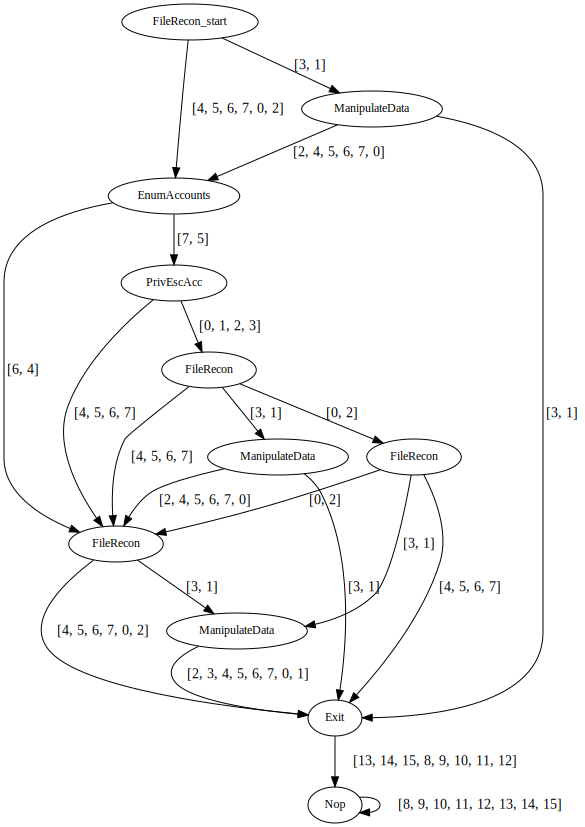

Displaying /home/ashinde/PhD/CaffineBravery/results_l2/264394929_attl0_pol_graph.json
Edge map is:
0:[(AccessPerm, auth), (HostObs, user_files), (ActionResult, failure), (ConnStatus, terminated)]
1:[(AccessPerm, auth), (HostObs, user_files), (ActionResult, success), (ConnStatus, terminated)]
2:[(AccessPerm, auth), (HostObs, none), (ActionResult, failure), (ConnStatus, terminated)]
3:[(AccessPerm, auth), (HostObs, none), (ActionResult, success), (ConnStatus, terminated)]
4:[(AccessPerm, denied), (HostObs, user_files), (ActionResult, failure), (ConnStatus, terminated)]
5:[(AccessPerm, denied), (HostObs, user_files), (ActionResult, success), (ConnStatus, terminated)]
6:[(AccessPerm, denied), (HostObs, none), (ActionResult, failure), (ConnStatus, terminated)]
7:[(AccessPerm, denied), (HostObs, none), (ActionResult, success), (ConnStatus, terminated)]
8:[(AccessPerm, denied), (HostObs, user_files), (ActionResult, failure), (ConnStatus, active)]
9:[(AccessPerm, auth), (HostObs, none), (Actio

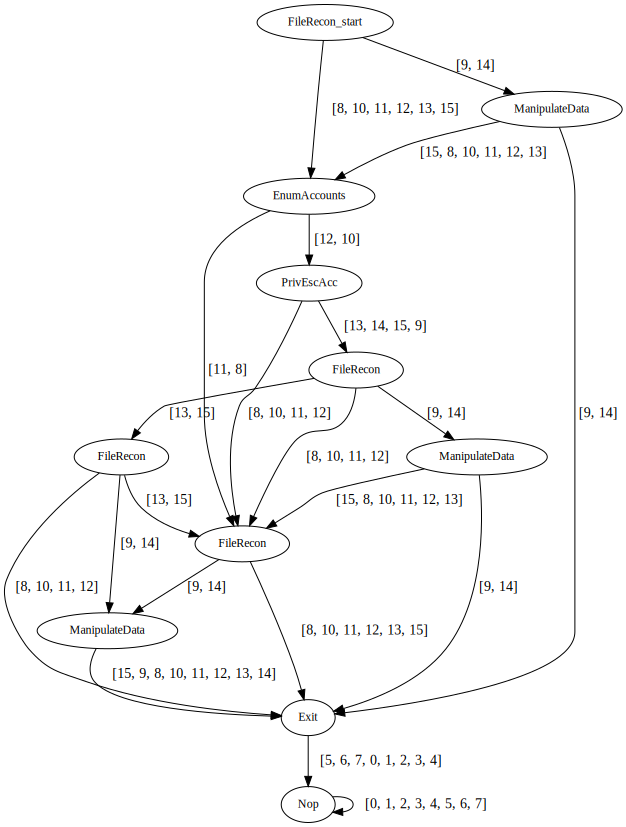

Displaying /home/ashinde/PhD/CaffineBravery/results_l2/631673932_defl1_active_pol_graph.json
Edge map is:
0:[(EndPtAlerts, file_enum)]
1:[(EndPtAlerts, file_write)]
2:[(EndPtAlerts, login_activity)]
3:[(EndPtAlerts, none)]


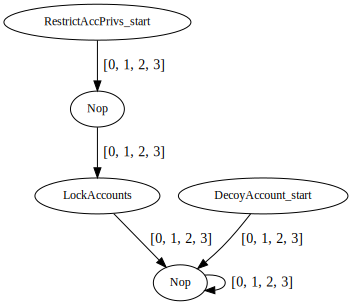

Displaying /home/ashinde/PhD/CaffineBravery/results_l2/1579132337_defl1_passive_pol_graph.json
Edge map is:
0:[(EndPtAlerts, file_enum)]
1:[(EndPtAlerts, file_write)]
2:[(EndPtAlerts, login_activity)]
3:[(EndPtAlerts, none)]


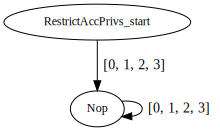

Displaying /home/ashinde/PhD/CaffineBravery/results_l2/1252540239_attl2_pol_graph.json
Edge map is:
0:[(AccessPerm, auth), (HostObs, user_files), (ActionResult, failure), (ConnStatus, active), (DefenseObs, perms_change)]
1:[(AccessPerm, auth), (HostObs, user_files), (ActionResult, failure), (ConnStatus, active), (DefenseObs, acc_policy_change)]
2:[(AccessPerm, auth), (HostObs, user_files), (ActionResult, failure), (ConnStatus, active), (DefenseObs, none)]
3:[(AccessPerm, auth), (HostObs, none), (ActionResult, failure), (ConnStatus, active), (DefenseObs, acc_policy_change)]
4:[(AccessPerm, auth), (HostObs, none), (ActionResult, failure), (ConnStatus, active), (DefenseObs, perms_change)]
5:[(AccessPerm, auth), (HostObs, none), (ActionResult, failure), (ConnStatus, active), (DefenseObs, none)]
6:[(AccessPerm, auth), (HostObs, user_files), (ActionResult, success), (ConnStatus, active), (DefenseObs, none)]
7:[(AccessPerm, auth), (HostObs, user_files), (ActionResult, success), (ConnStatus, a

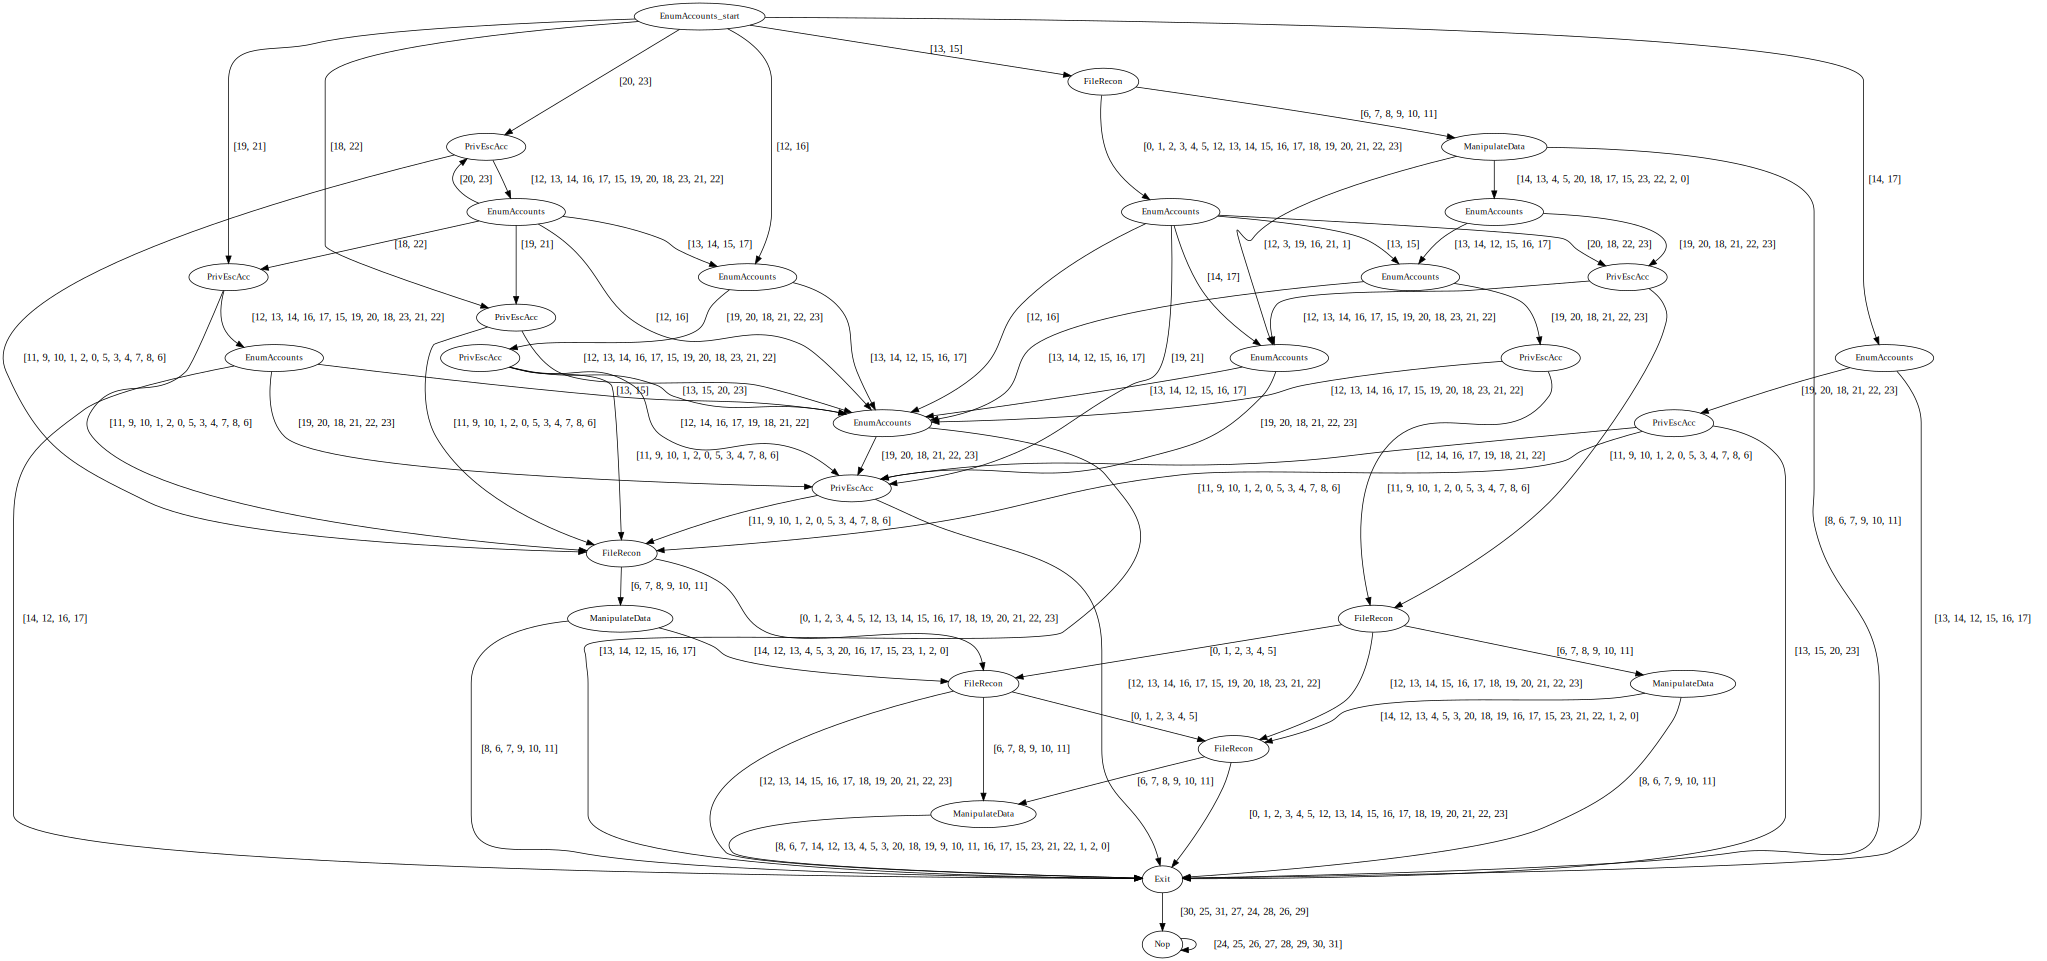

In [5]:
GRAPH_FILES = list(filter(lambda x: "pol_graph" in x.parts[-1], DATA_FILES))

for g in GRAPH_FILES:
    print(f"Displaying {g}")
    data = load_json(g)
    G = get_graphviz_graph(data)
    display(G)

---
Summarize the actual interactions

In [6]:
# Get the trace files
TRACE_FILES = list(filter(lambda x: "trace" in x.parts[-1], DATA_FILES))

for _file in TRACE_FILES:
    print(f"Using trace from {_file}")


Using trace from /home/ashinde/PhD/CaffineBravery/results_l2/trace.0.json
Using trace from /home/ashinde/PhD/CaffineBravery/results_l2/trace.1.json
Using trace from /home/ashinde/PhD/CaffineBravery/results_l2/trace.2.json
Using trace from /home/ashinde/PhD/CaffineBravery/results_l2/trace.3.json
Using trace from /home/ashinde/PhD/CaffineBravery/results_l2/trace.4.json


In [7]:
# Summarize beliefs
def summarize_beliefs(state_vars, dataframe):
    
    agent_i_data = filter_columns_by_agent(dataframe, "")

# Use state data to figure out the state variables
def get_state_vars(columns):
    
    states = filter(lambda x: "state" in x.split(".") and len(x.split(".")) >= 2, columns)
    state_vars = map(lambda x: x.split(".")[1], states)
    
    return list(set(state_vars))

# Fetch dataframe with columns belonging to a particular agent
def filter_columns_by_agent(dataframe, name):
    columns = dataframe.columns
    filtered_columns = list(filter(lambda x: name in x.split("."), columns))
    
    df = dataframe[filtered_columns]
    return df

# Main loop to summarize all traces
for trace in TRACE_FILES:
    data = load_json(trace)
    
    dataframe = pandas.json_normalize(data)    
    state_vars = get_state_vars(dataframe.columns)

    

---
## Beliefs 

In [ ]:
import summarize_interaction

# load json data
data = load_json(trace_file)

keys, b_traces = summarize_interaction.get_all_belief_traces(data)

print("Plotting belief divergence over")
for k in keys:
    print(k)

In [ ]:
# Get divergence
divs = []
for b_trace in b_traces:
    divs.append(summarize_interaction.get_divergence(b_trace))
    
for i in range(len(keys)):
    print(f"Plotting for {keys[i]}")
    
    i_means = numpy.mean(divs[i][0], axis=0)
    i_dev = numpy.std(divs[i][0], axis=0)
    plotter.errorbar(numpy.linspace(1, i_means.shape[0], i_means.shape[0]), i_means, fmt='r-.', yerr=i_dev, linewidth=0.5)
    
    if len(divs[i]) > 1:
        j_means = numpy.mean(divs[i][1], axis=0)
        j_dev = numpy.std(divs[i][1], axis=0)
        plotter.errorbar(numpy.linspace(1, j_means.shape[0], j_means.shape[0]), j_means, fmt='b-.', yerr=j_dev, linewidth=0.5)
        # plotter.plot(divs[i][1].T, 'b-.', linewidth=0.5)
    
    plotter.ylim(-0.1, 2)
    plotter.show()
    

---
# Display interaction examples

In [ ]:
from functools import reduce

for trace in data[:5]:
    actions = summarize_interaction.pull_actions(trace)
    display(actions)
    
    try:
        frame_beliefs = summarize_interaction.pull_frame_beliefs(trace)
        
        i_PAj = summarize_interaction.pull_from_trace(trace, lambda x: x, "i_P(Aj)")
        i_PAj = list(reduce(lambda a, b: a + b, map(lambda x: list(x.values()), i_PAj)))
        i_PAj = pandas.DataFrame.from_dict(i_PAj)
        print("Agent i's P(Aj)")
        display(i_PAj)

        j_PAj = summarize_interaction.pull_from_trace(trace, lambda x: x, "j_P(Aj)")
        j_PAj = list(reduce(lambda a, b: a + b, map(lambda x: list(x.values()), j_PAj)))
        j_PAj = pandas.DataFrame.from_dict(j_PAj)
        print("Agent j's P(Aj)")
        display(j_PAj)

        for _b_theta in frame_beliefs:
            display(_b_theta)
            _b_theta.plot(linewidth=0.5)
            plotter.ylim(-0.1, 1.1)
            plotter.show()
    except Exception as e:
        print(e)
        
    for k in keys:
        beliefs = summarize_interaction.show_belief(trace, k)

        for _b in beliefs.keys():
            print(f"Showing {k} for {_b}")
            display(beliefs[_b])

            print(f"Plotting {k} for {_b}")
            beliefs[_b].plot(legend=True, title=k[0], linewidth=0.5)
            plotter.ylim(-0.1, 1.1)
            plotter.show()

    print("=============== End interaction trace")
    